In [1]:
!pip install lightgbm

  Using cached lightgbm-3.3.2-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.2 MB)


In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
import lightgbm as lgb

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
def plot_confusion_matrix(y_true, y_predict, xticklabels, yticklabels):
    cm = confusion_matrix(y_true, y_predict)
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', cbar=False, xticklabels=xticklabels,
                yticklabels=yticklabels, linewidths='0.1', linecolor='black')
    plt.show()

In [4]:
url = '../Lecture/Lecture_05_ensemble_learning/cs-training.csv'
df = pd.read_csv(url).drop(columns='Unnamed: 0')
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
df.columns.to_list()

['SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

### Feature Engineering

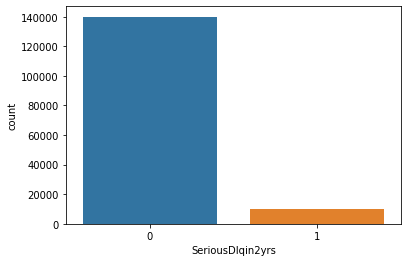

In [8]:
sns.countplot(data=df, x='SeriousDlqin2yrs');

In [11]:
df.SeriousDlqin2yrs.value_counts(normalize=True)

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

In [12]:
df.shape

(150000, 11)

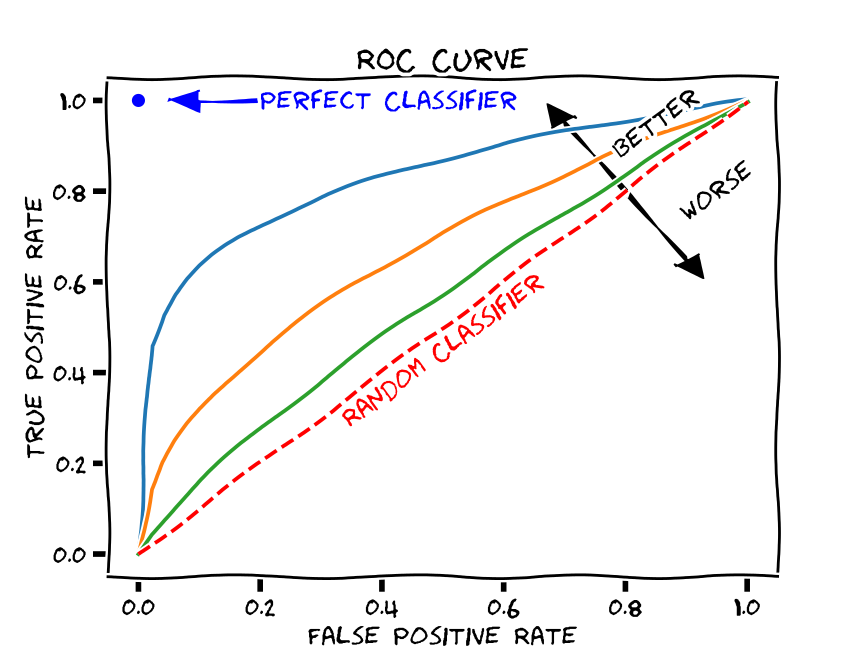

In [13]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


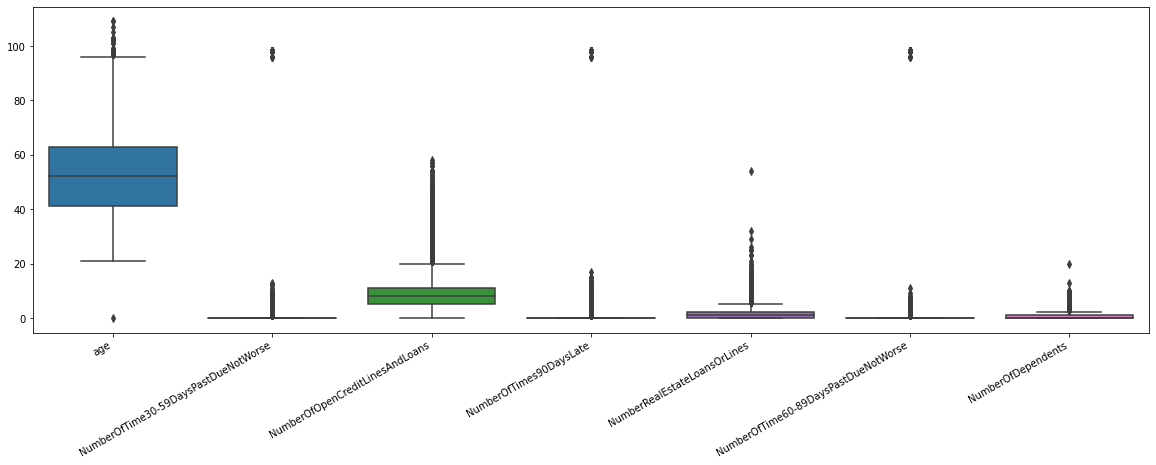

In [26]:
plt.figure(figsize=(20, 6))
ax = sns.boxplot(data=df.iloc[:, 1:].drop(columns=['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']))
ax.set_xticklabels(labels=df.iloc[:, 1:].drop(columns=['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']).columns.to_list(), 
                   rotation=30, ha='right');

In [31]:
df.RevolvingUtilizationOfUnsecuredLines.quantile(0.99)

1.0929557681400022

In [45]:
100 - df[(df.RevolvingUtilizationOfUnsecuredLines > 1.3)].shape[0] / df.shape[0] * 100

99.44466666666666

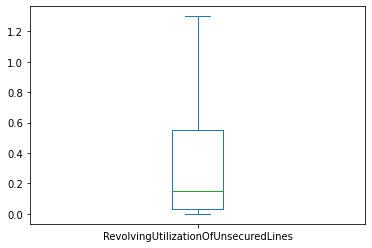

In [42]:
df[(df.RevolvingUtilizationOfUnsecuredLines < 1.3)].RevolvingUtilizationOfUnsecuredLines.plot(kind='box');

#### Sanity check

In [46]:
df.shape

(150000, 11)

In [49]:
df.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

In [51]:
df.duplicated().sum()

609

In [54]:
df[df.duplicated(keep=False)].sort_values(by=['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'MonthlyIncome'])

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
134365,0,0.0,21,0,0.0,0.0,1,0,0,0,0.0
137102,0,0.0,21,0,0.0,0.0,1,0,0,0,0.0
25632,0,0.0,21,0,0.0,820.0,2,0,0,0,0.0
83552,0,0.0,21,0,0.0,820.0,2,0,0,0,0.0
139345,0,0.0,21,0,0.0,820.0,2,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70202,1,1.0,55,0,0.0,1000.0,0,1,0,0,0.0
45368,1,1.0,55,98,0.0,NaN,0,98,0,98,0.0
115871,1,1.0,55,98,0.0,NaN,0,98,0,98,0.0
50783,1,1.0,57,0,0.0,NaN,0,0,0,0,0.0


In [55]:
df.drop_duplicates(inplace=True)

### Baseline

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.SeriousDlqin2yrs, test_size=0.15, shuffle=True, 
                                                    random_state=4, stratify=df.SeriousDlqin2yrs)
valid_size = y_test.shape[0] / y_train.shape[0]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, shuffle=True, random_state=4, stratify=y_train)

In [58]:
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape), (X_test.shape, y_test.shape)

(((104573, 10), (104573,)), ((22409, 10), (22409,)), ((22409, 10), (22409,)))

In [61]:
df.SeriousDlqin2yrs.value_counts(normalize=True) * 100

0    93.300132
1     6.699868
Name: SeriousDlqin2yrs, dtype: float64

In [65]:
print(f'{y_train.value_counts(normalize=True) * 100}')
print('-'*100)
print(f'{y_valid.value_counts(normalize=True) * 100}')
print('-'*100)
print(f'{y_test.value_counts(normalize=True) * 100}')

0    93.299418
1     6.700582
Name: SeriousDlqin2yrs, dtype: float64
----------------------------------------------------------------------------------------------------
0    93.301798
1     6.698202
Name: SeriousDlqin2yrs, dtype: float64
----------------------------------------------------------------------------------------------------
0    93.301798
1     6.698202
Name: SeriousDlqin2yrs, dtype: float64


In [66]:
train_set = lgb.Dataset(X_train, y_train)
valid_set = lgb.Dataset(X_valid, y_valid)
test_set = lgb.Dataset(X_test, y_test)

In [70]:
params = {'num_boost_round': 1000}
evals_result = {}
model = lgb.train(params, train_set=train_set, valid_sets=[train_set, valid_set], evals_result=evals_result, verbose_eval=10)

/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will b

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 104573, number of used features: 10
[LightGBM] [Info] Start training from score 0.067006
[10]	training's l2: 0.0506673	valid_1's l2: 0.0513652
[20]	training's l2: 0.0484512	valid_1's l2: 0.0498613
[30]	training's l2: 0.0475556	valid_1's l2: 0.0496014
[40]	training's l2: 0.0469346	valid_1's l2: 0.0495493
[50]	training's l2: 0.0464581	valid_1's l2: 0.0495415
[60]	training's l2: 0.0460856	valid_1's l2: 0.0495611
[70]	training's l2: 0.0457369	valid_1's l2: 0.0495528
[80]	training's l2: 0.0453887	valid_1's l2: 0.0495854
[90]	training's l2: 0.0451083	valid_1's l2: 0.0496331
[100]	training's l2: 0.044838	valid_1's l2: 0.049732
[110]	training's l2: 0.0445654	valid_1's l2: 0.04975

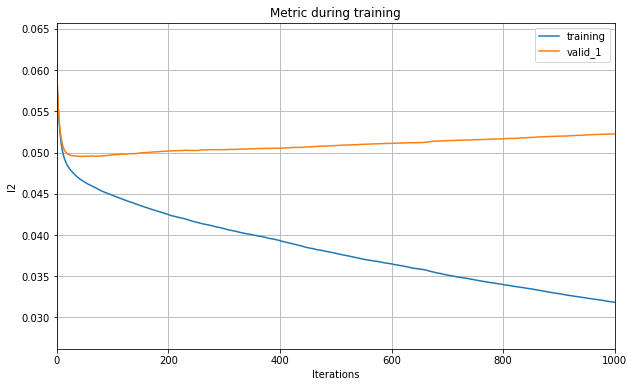

In [71]:
lgb.plot_metric(evals_result, metric='l2', figsize=(10, 6));

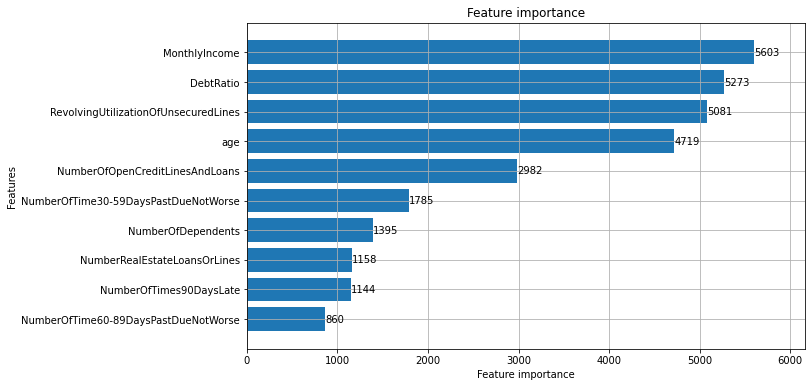

In [73]:
lgb.plot_importance(model, figsize=(10, 6), height=0.8);

In [75]:
threshold = 0.5
predicted_proba = model.predict(X_test)
predicted_label = np.where(predicted_proba >= 0.5, 1, 0)

In [76]:
print(classification_report(y_test, predicted_label))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     20908
           1       0.53      0.20      0.29      1501

    accuracy                           0.93     22409
   macro avg       0.74      0.59      0.63     22409
weighted avg       0.92      0.93      0.92     22409



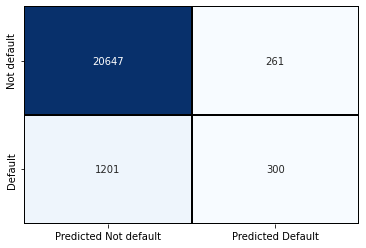

In [80]:
plot_confusion_matrix(y_test, predicted_label, ['Predicted Not default', 'Predicted Default'], ['Not default', 'Default'])

### Improvement

In [88]:
params = {'objective': 'binary',
          'metric': ['auc', 'binary_logloss'],
          'boosting': 'gbdt',
          'learning_rate': 0.001,
          'num_threads': 8,
          'num_leaves': 6,
          'min_data_in_leaf': 1000,
          'max_depth': 4,
          'num_boost_round': 5000,
          'early_stopping_round': 1000,
#           'first_metric_only': True
         }
evals_result = {}
model = lgb.train(params, train_set=train_set, valid_sets=[train_set, valid_set], evals_result=evals_result, verbose_eval=500)

/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will b

[LightGBM] [Info] Number of positive: 7007, number of negative: 97566
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 104573, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067006 -> initscore=-2.633619
[LightGBM] [Info] Start training from score -2.633619
Training until validation scores don't improve for 1000 rounds
[500]	training's auc: 0.84155	training's binary_logloss: 0.206952	valid_1's auc: 0.83688	valid_1's binary_logloss: 0.206976
[1000]	training's auc: 0.848955	training's binary_logloss: 0.194185	valid_1's auc: 0.842985	valid_1's binary_logloss: 0.194474
[1500]	training's auc: 0.853126	training's binary_logloss: 0.188014	valid_1's auc: 0.847642	valid_1's binary_logloss: 0.188682

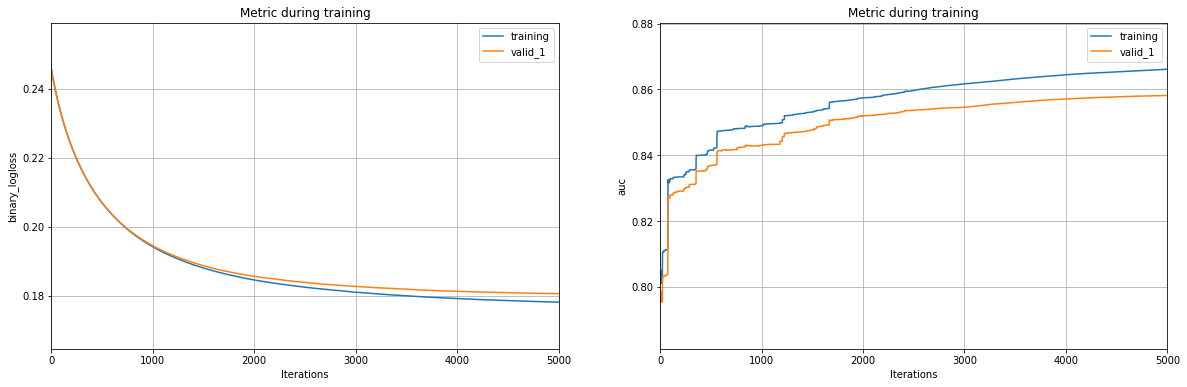

In [89]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
lgb.plot_metric(evals_result, metric='binary_logloss', ax=ax[0])
lgb.plot_metric(evals_result, metric='auc', ax=ax[1]);

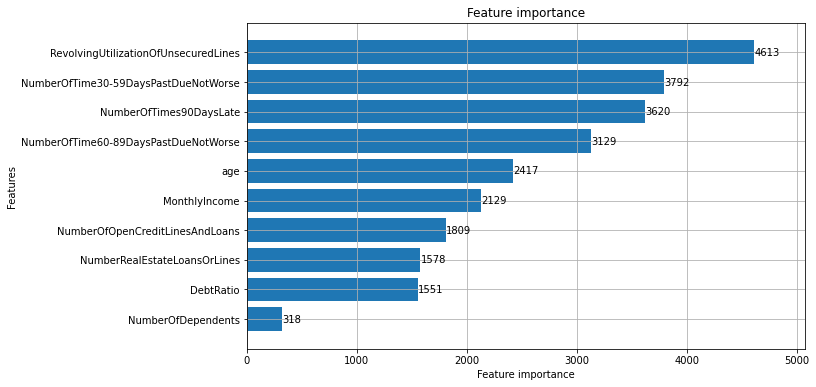

In [90]:
lgb.plot_importance(model, figsize=(10, 6), height=0.8);

In [105]:
predicted_proba = model.predict(X_test)

In [108]:
threshold = 0.25
predicted_label = np.where(predicted_proba >= threshold, 1, 0)

In [109]:
print(classification_report(y_test, predicted_label))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     20908
           1       0.44      0.46      0.45      1501

    accuracy                           0.92     22409
   macro avg       0.70      0.71      0.70     22409
weighted avg       0.93      0.92      0.93     22409



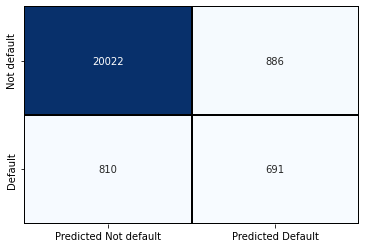

In [110]:
plot_confusion_matrix(y_test, predicted_label, ['Predicted Not default', 'Predicted Default'], ['Not default', 'Default'])

In [100]:
thresholds = list(np.arange(0.1, 1, 0.1))
precisions, recalls = [], []
for thresh in thresholds:
    predicted_label = np.where(predicted_proba >= thresh, 1, 0)
    precisions.append(precision_score(y_test, predicted_label))
    recalls.append(recall_score(y_test, predicted_label))

/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nguyen_truong/opt/anaconda3/envs/MCI_PY30SA12_L2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


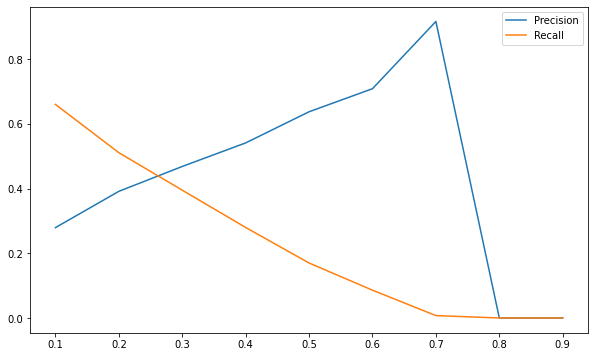

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.legend()
plt.show()